Data Description: Amazon Reviews data. The repository has several datasets. For this case study, we are using the Electronics dataset. 

Domain: E-commerce 

Context: Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time. 

Attribute Information: ● userId : Every user identified with a unique id
● productId : Every product identified with a unique id
● Rating : Rating of the corresponding product by the corresponding user
● timestamp : Time of the rating 

Objective: Build a recommendation system to recommend products to customers based on the their previous ratings for other products.



# 1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) 

# Import Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

%matplotlib inline


# Load the Dataset and Add headers

In [2]:
electronics_data = pd.read_csv("ratings_Electronics.csv") 
electronics_data.columns = ['userId','productId','Rating','timestamp']
electronics_data.head()


,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [3]:
# Display the data

electronics_data.head()


,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [4]:
#Shape of the data
electronics_data.shape

(1048575, 4)

In [5]:
#Taking subset of the dataset
electronics_data=electronics_data.iloc[:1048576,0:]

In [6]:
#Check the datatypes
electronics_data.dtypes

userId       object
productId    object
Rating        int64
timestamp     int64
dtype: object

In [7]:
electronics_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1048575 non-null  object
 1   productId  1048575 non-null  object
 2   Rating     1048575 non-null  int64 
 3   timestamp  1048575 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


In [8]:
#Five point summary 

electronics_data.describe()['Rating'].T


count    1.048575e+06
mean     3.973379e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

## Handling Missing values


In [10]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_data.isnull().sum())



Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


## Ratings

C:\Users\Prashant Varshney\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Prashant Varshney\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


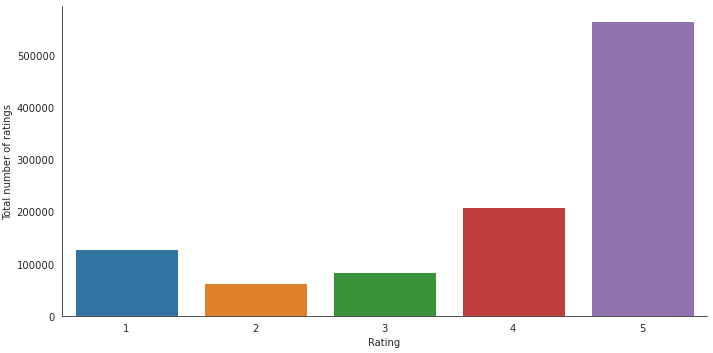

In [11]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

Most of the people has given the rating of 5

## Unique Users and products


In [12]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 1048575
Total No of Users   : 786329
Total No of products  : 61893


## Dropping the TimeStamp Column

In [13]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

# Analyzing the rating

In [14]:
#Analysis of rating given by the user 

no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()


count    786329.000000
mean          1.333507
std           1.385613
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [16]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')


# 2. Take a subset of the dataset to make it less sparse/ denser.  ( For example, keep the users only who has given 50 or  more number of ratings ) 

In [17]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )



 No of rated product more than 50 per user : 38



In [18]:
#Getting the new dataframe which contains users who has given 50 or more ratings

new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

# 3. Split the data randomly into train and test dataset. ( For  example, split it in 70/30 ratio) 

In [19]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [20]:
#Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10) 

# 4. Build Popularity Recommender model. 

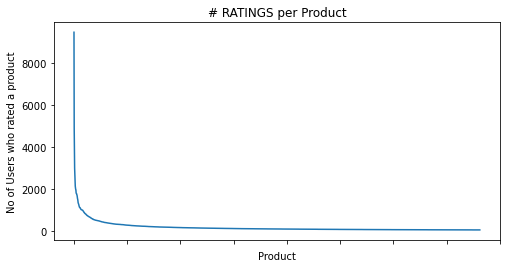

In [21]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of Users who rated a product')
ax.set_xticklabels([])

plt.show()

In [22]:
#Average rating of the product 

new_df.groupby('productId')['Rating'].mean().head()

productId
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
1400532655    3.727273
Name: Rating, dtype: float64

In [23]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()


productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [24]:
#Total no of rating for product

new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [25]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())


In [26]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())


In [27]:
ratings_mean_count.head()


,Rating,rating_counts
productId,,
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171
1400532655,3.727273,484


In [28]:
ratings_mean_count['rating_counts'].max()


9487

Text(0.5, 0, 'Number of Ratings')

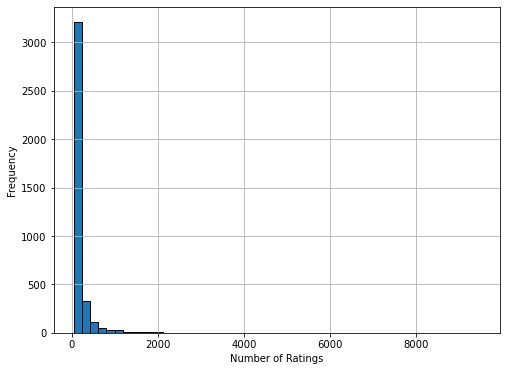

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)
plt.ylabel("Frequency")
plt.xlabel("Number of Ratings")

Text(0.5, 0, 'Mean Ratings')

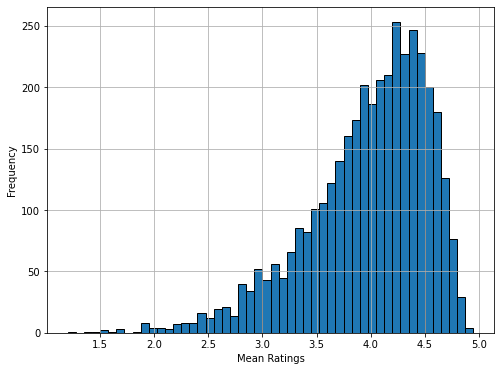

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)
plt.ylabel("Frequency")
plt.xlabel("Mean Ratings")

<Figure size 576x432 with 0 Axes>

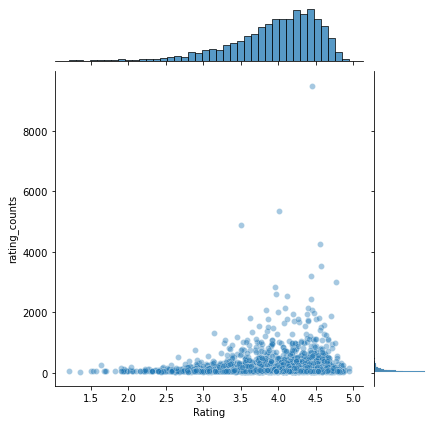

In [31]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)


<AxesSubplot:xlabel='productId'>

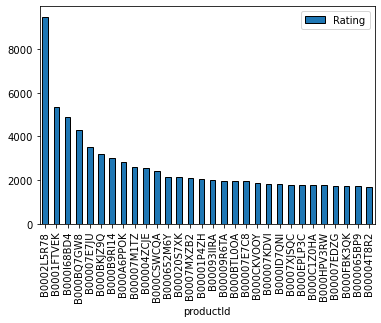

In [32]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

# 5. Build Collaborative Filtering model. 

In [33]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [34]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [35]:
test_pred


[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0,

# 6. Evaluate the models. 
(Once the model is trained on  the training data, it can be used to compute the error  (RMSE) on predictions made on the test data).

In [36]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

# 7. Get top - K ( K = 5) recommendations. Since our goal is to  recommend new products for each user based on his/her  habits, we will recommend 5 new products

In [37]:

new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,3744295508,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.



In [38]:
ratings_matrix.shape


(9832, 76)

Transposing the matrix

In [39]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0


In [40]:
X.shape


(76, 9832)

Unique products in subset of data


In [42]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [43]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape
print(correlation_matrix)

[[ 1.          0.95925122  0.95794116 ...  0.83988474  0.10345871
   0.33746313]
 [ 0.95925122  1.          0.92735644 ...  0.69295973 -0.09366733
   0.51161318]
 [ 0.95794116  0.92735644  1.         ...  0.86623148  0.24542302
   0.21006041]
 ...
 [ 0.83988474  0.69295973  0.86623148 ...  1.          0.60659668
  -0.21132989]
 [ 0.10345871 -0.09366733  0.24542302 ...  0.60659668  1.
  -0.86669098]
 [ 0.33746313  0.51161318  0.21006041 ... -0.21132989 -0.86669098
   1.        ]]


In [44]:
X.index[70]


'B00000JMUG'

Index # of product ID purchased by customer



In [45]:
i = "B00000JMUG"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

70

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [46]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

Recommending top 5 highly correlated products in sequence



In [47]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:5]

['7214047977', '8862935293', '9888002198', 'B00000IGBF', 'B00000J1QK']

Here are the top 05 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.
'7214047977', '8862935293', '9888002198', 'B00000IGBF', 'B00000J1QK' are the top recommended products for the customer who purchased a product 'B00000JMUG'.
The most popular product recommended to the user is : B0002L5R78